In [2]:
print("""
@Description: 
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-08-06 20:16:20
""")


@Description: 
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-08-06 20:16:20



In [3]:
import pandas as pd
import numpy as np

In [4]:
train_data = pd.read_csv('data/GiveMeSomeCredit-training.csv', index_col=0)

In [5]:
train_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
train_data.shape

(150000, 11)

In [7]:
train_data.describe(percentiles=[.5]).T

,count,mean,std,min,50%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.154181,50708.0
age,150000.0,52.295207,14.771866,0.0,52.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.366508,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,5400.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,8.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,1.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,98.0


In [8]:
train_data.columns = train_data.columns.str.replace('-', '')
# 移除字段名中的一些 -, 因为这些字符会被识别为减号，或者被用来分割

In [9]:
train_data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime3059DaysPastDueNotWorse     0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime6089DaysPastDueNotWorse     0.000000
NumberOfDependents                      0.026160
dtype: float64

# 数据清洗

## 去重

In [10]:
train_data = train_data.drop_duplicates()
train_data.shape

(149391, 11)

## 缺失值处理

1. 占比超过 80%，直接删除改字段（特征）
2. 占比超过 30%，将缺失值做一个类别或者值
   - 如果字段是连续的，则其他已有值分箱
   - 如果字段是分类的，考虑其他分类是否需要重新分箱
3. 占比超过 10%，多重插补
4. 其他，中位数或者众数

### 查看缺失值分布情况

In [11]:
import missingno as msno
import matplotlib.pyplot as plt

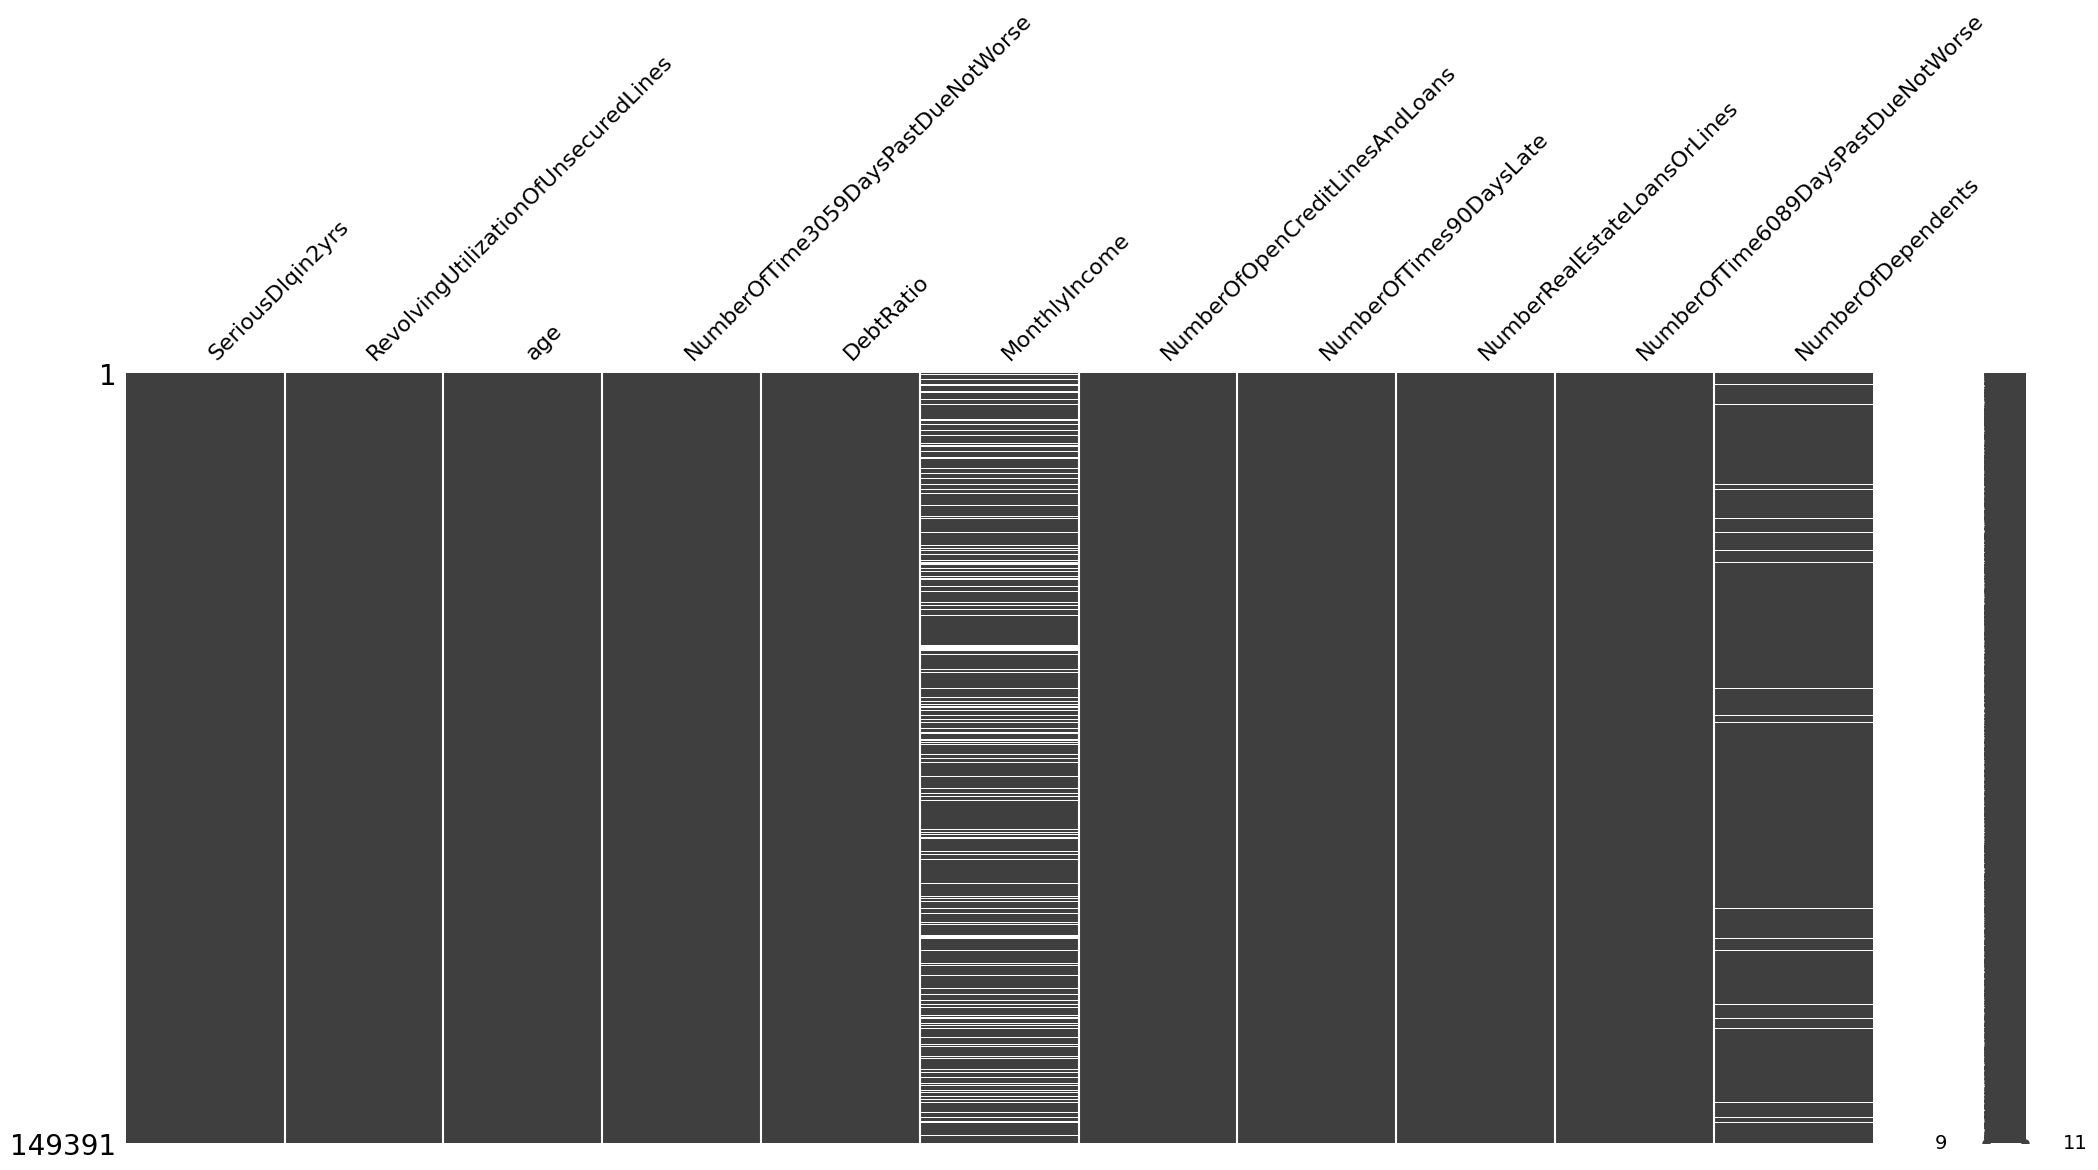

In [12]:
msno.matrix(train_data)
plt.show()

In [13]:
# plt.imshow(~train_data.isnull(), aspect='auto')
# plt.gray()

### 演示算法填补

In [15]:
from statsmodels.imputation import mice
imdata = train_data.copy()
imp = mice.MICEData(imdata)
imp.update_all(20)

In [16]:
assert not imp.data.isnull().any().any()

In [39]:
from sklearn.ensemble import RandomForestRegressor


def imputation_missing(data, to_fill):
    df = data.copy()
    columns = [*data.columns]
    # 这里必须移除全部的其他含缺失值的字段
    columns.remove('NumberOfDependents')
    # 不要包含 label
    columns.remove('SeriousDlqin2yrs')
    columns.remove(to_fill)
    X = df.loc[:, columns]
    Y = df.loc[:, to_fill]
    not_null_mask = df[to_fill].notnull()
    X_train = X.loc[not_null_mask]
    Y_train = Y.loc[not_null_mask]
    X_pred = X.loc[~not_null_mask]
    model = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=3, n_jobs=-1)
    model.fit(X_train, Y_train)
    pred = model.predict(X_pred)
    df.loc[~not_null_mask, to_fill] = pred
    return df

In [33]:
train_data = imputation_missing(train_data, 'MonthlyIncome')

In [38]:
train_data.notna().all()

SeriousDlqin2yrs                         True
RevolvingUtilizationOfUnsecuredLines     True
age                                      True
NumberOfTime3059DaysPastDueNotWorse      True
DebtRatio                                True
MonthlyIncome                            True
NumberOfOpenCreditLinesAndLoans          True
NumberOfTimes90DaysLate                  True
NumberRealEstateLoansOrLines             True
NumberOfTime6089DaysPastDueNotWorse      True
NumberOfDependents                      False
dtype: bool

In [48]:
from scipy import stats as st
mode_value = st.mode(train_data['NumberOfDependents'].values)[0]
train_data['NumberOfDependents'] = train_data['NumberOfDependents'].fillna(mode_value)
# np.mode(train_data['NumberOfDependents'].values)

In [50]:
assert train_data.notna().all().all()

### 异常值处理

#### 盖帽法

In [51]:
def block(x, lower = True, upper = True):
    q_lower = x.quantile(.01)
    q_upper = x.quantile(.99)
    if lower:
        out = x.mask(x<q_lower, q_lower)
    if upper:
        out = x.mask(x>q_upper, q_upper)
    return out

In [59]:
x = train_data['NumberOfDependents'].quantile(.99)
train_data['NumberOfDependents'].mask(train_data['NumberOfDependents'] > x, x)

1         2.0
2         1.0
3         0.0
4         0.0
5         0.0
         ... 
149996    0.0
149997    2.0
149998    0.0
149999    0.0
150000    0.0
Name: NumberOfDependents, Length: 149391, dtype: float64

In [58]:
train_data['NumberOfDependents']

1         2.0
2         1.0
3         0.0
4         0.0
5         0.0
         ... 
149996    0.0
149997    2.0
149998    0.0
149999    0.0
150000    0.0
Name: NumberOfDependents, Length: 149391, dtype: float64

In [60]:
s = pd.Series(range(5))
t = pd.Series([True, False])

In [66]:
s.where(t, 99) # 是默认全不满足
# t = pd.Series([True, False, False, False, False])

0     0
1    99
2     2
3     3
4     4
dtype: int64

In [65]:
s.mask(t, 999) # 默认全满足
# t = pd.Series([True, False, True, True, True])